In [1]:
# !pip install stim -q
# !pip install stimcirq -q
# !pip install pymatching~=2.0 -q

In [2]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))  # increase cell width
display(
    HTML("<style>div.output_area pre {white-space: pre;}</style>")
)  # horizontal scrolling instead of newlines for printed output
%reload_ext autoreload
%autoreload 2

In [3]:
import stim
import cirq
import stimcirq
import qldpc
import pymatching
import numpy as np
import cirq_superstaq as css

In [137]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int, decompose_errors=True, ignore_decomposition_failures=False) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model()
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [138]:
surface_code = qldpc.codes.SurfaceCode(3, rotated=True)
surface_code.reduce_logical_ops()

def gen_syndrome_surface_circuit(surface_code, repetitions=1, error_rate=0.01):
    circuit = cirq.Circuit()
    stab_circuit = cirq.Circuit()

    logical_x = surface_code.get_logical_ops(qldpc.objects.Pauli.X)
    logical_z = surface_code.get_logical_ops(qldpc.objects.Pauli.Z)

    count = 0
    measures = []
    hs = []
    for anc_idx, row in enumerate(surface_code.matrix_x):
        count += 1
        anc = cirq.NamedQubit(f"a{anc_idx}")
        stab_circuit += cirq.H(anc)
        for bit_idx, bit in enumerate(row):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CX(anc, cirq.LineQubit(bit_idx))
        hs.append(cirq.H(anc))
        measures.append(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key="").on(anc))

    stab_circuit += cirq.Moment(hs)
    for anc_idx, row in enumerate(surface_code.matrix_z, start=count):
        anc = cirq.NamedQubit(f"a{anc_idx}")
        for bit_idx, bit in enumerate(row):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CX(anc, cirq.LineQubit(bit_idx))
        measures.append(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key="").on(anc))

    # First round of stabilizer checks
    circuit = stab_circuit.copy()
    
    circuit += cirq.Moment(measures)

    ancillas = sorted([q for q in circuit.all_qubits() if isinstance(q, cirq.NamedQubit)])
    data = sorted([q for q in circuit.all_qubits() if q not in ancillas])

    circuit += cirq.Moment([cirq.X.with_probability(error_rate).on(anc) for anc in ancillas])
    circuit += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[x], coordinate_metadata = (i, 0)) for i, x in enumerate(range(-len(ancillas), int(-len(ancillas)/2)))])


    
    # Repeat Block
    circuit_op = stab_circuit
    moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key=idx + 7).on(anc)] for idx, anc in enumerate(ancillas))
    moment += cirq.Moment([stimcirq.ShiftCoordsAnnotation((0, 1))])
    circuit_op += moment
    circuit_op += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[x, x-len(ancillas)], coordinate_metadata = (i, 0)) for i, x in enumerate(range(-len(ancillas), 0))])
    circuit += cirq.Circuit(cirq.CircuitOperation(cirq.FrozenCircuit(circuit_op), repetitions=repetitions - 1, use_repetition_ids=False))


    for idx, d in enumerate(data):
        circuit += cirq.Z.with_probability(error_rate).on(d) 
        circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=False, basis='X', invert_measure=False, key=idx).on(d)
    
    moment = []
    for i, anc_idx in enumerate(range(len(ancillas)//2)):
        data_indices = [idx - len(data) for idx, element in enumerate(surface_code.matrix_x[anc_idx]) if element == 1]
        moment.append(stimcirq.DetAnnotation(relative_keys=[anc_idx - len(circuit.all_qubits())] + data_indices, coordinate_metadata = (i, 1)))

    circuit += cirq.Moment(moment)

    for i, lx in enumerate(logical_x):
        observable_keys = [idx - len(data) for idx, element in enumerate(lx) if element == 1]
        circuit += cirq.Moment(stimcirq.CumulativeObservableAnnotation(parity_keys=[], relative_keys=observable_keys, observable_index=i))

    # circuit.insert(0, cirq.reset_each(*circuit.all_qubits()))
    moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key="").on(q) for q in data])
    moment += cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='Z', invert_measure=False, key="").on(q) for q in ancillas])
    circuit.insert(0, moment)
    # return circuit.with_noise(cirq.depolarize(error_rate))
    return circuit

surface_circuit = gen_syndrome_surface_circuit(surface_code, 10)
# surface_circuit

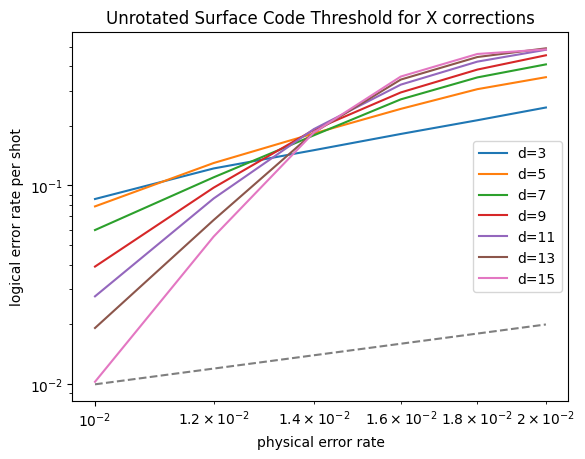

In [139]:
import matplotlib.pyplot as plt

num_shots = 10_000
for d in [3, 5, 7, 9, 11, 13, 15]:
    sc = qldpc.codes.SurfaceCode(d, rotated=False)
    xs = []
    ys = []
    for noise in [0.01, 0.012, 0.014, 0.016, 0.018, 0.02]:
        circuit = stimcirq.cirq_circuit_to_stim_circuit(gen_syndrome_surface_circuit(sc, 3*d, noise))
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.plot(xs, xs, "--")
plt.loglog()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.title("Unrotated Surface Code Threshold for X corrections")
plt.legend()
plt.show()

In [140]:
from sympy.abc import x, y, z
dims = {x: 12, y: 6}
poly_a = x**3 + y + y**2
poly_b = y**3 + x + x**2

code = qldpc.codes.BBCode(dims, poly_a, poly_b)

In [141]:
import matplotlib.pyplot as plt
code = qldpc.codes.BBCode(dims, poly_a, poly_b)

num_shots = 10_000
xs = []
ys = []
for noise in [0.00002, 0.00004, 0.00006, 0.00008, 0.0001]:
    circuit = stimcirq.cirq_circuit_to_stim_circuit(gen_syndrome_surface_circuit(code, 12, noise))
    num_errors_sampled = count_logical_errors(circuit, num_shots, False, False)
    xs.append(noise)
    ys.append(num_errors_sampled / num_shots)
plt.plot(xs, ys)
plt.plot(xs, xs, "--")
plt.loglog()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.title("Unrotated Surface Code Threshold for X corrections")
plt.legend()
plt.show()

ValueError: No perfect matching could be found. This likely means that the syndrome has odd parity in the support of a connected component without a boundary.

In [147]:
circuit.diagram(
    "detslice-with-ops-svg",
    tick=range(771, 775),
    filter_coords=["D1368", "D1369", "D1424"],
)

In [146]:
dem = circuit.detector_error_model()
# print(repr(dem))

# Code Archive

In [ ]:
def stim_steane_code(error_rate):
# steane code metadata
    steane_code = qldpc.codes.SteaneCode()
    code = steane_code
    repetitions = 10
    stabilizers = []
    
    circuit = cirq.Circuit()
    ancillas = []
    stab_circuit = cirq.Circuit()
    for anc_idx, check in enumerate(code.matrix_x):
        anc = cirq.NamedQubit(f"a{anc_idx}")
        # anc = cirq.LineQubit(7 + anc_idx)
        ancillas.append(anc)
        stab_circuit += cirq.H(anc)
        for bit_idx, bit in enumerate(check):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CX(anc, cirq.LineQubit(bit_idx))
                stabilizers.append(cirq.CX(anc, cirq.LineQubit(bit_idx)))
        stab_circuit += cirq.H(anc)
        
    # circuit += css.barrier(*circuit.all_qubits())
    
    for anc_idx, check in enumerate(code.matrix_z):
        anc = cirq.NamedQubit(f"a{anc_idx + 3}")
        # anc = cirq.LineQubit(7 + 3 + anc_idx)
        ancillas.append(anc)
        stab_circuit += cirq.H(anc)
        for bit_idx, bit in enumerate(check):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CZ(anc, cirq.LineQubit(bit_idx))
                stabilizers.append(cirq.CZ(anc, cirq.LineQubit(bit_idx)))
        stab_circuit += cirq.H(anc)
    data = sorted([q for q in stab_circuit.all_qubits() if isinstance(q, cirq.LineQubit)])
    qubits = list(stab_circuit.all_qubits())
    
    circuit = cirq.Circuit()
    for q in qubits:
        # circuit += cirq.R(q)
        circuit += stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key="").on(q)
    stab_circuit = cirq.Circuit()
    stab_circuit += cirq.Moment([cirq.depolarize(error_rate).on(d) for d in data] + cirq.H.on_each(ancillas))
    stab_circuit += cirq.Circuit(cirq.Moment(stab) for stab in stabilizers)
    stab_circuit += cirq.Moment(cirq.H.on_each(ancillas))
    circuit += stab_circuit
    circuit += cirq.Moment([cirq.X.with_probability(error_rate).on(anc) for anc in ancillas])
    circuit += cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='X', invert_measure=False, key=idx + 7).on(anc)] for idx, anc in enumerate(ancillas))
    circuit += cirq.Moment(
        stimcirq.DetAnnotation(relative_keys=[-6], coordinate_metadata=(7.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-5], coordinate_metadata=(8.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-4], coordinate_metadata=(9.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-3], coordinate_metadata=(10.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-2], coordinate_metadata=(11.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-1], coordinate_metadata=(12.0, 0.0))
    )
    
    circuit_op = stab_circuit
    circuit_op += cirq.Moment([cirq.X.with_probability(error_rate).on(anc) for anc in ancillas])
    
    moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='X', invert_measure=False, key=idx + 7).on(anc)] for idx, anc in enumerate(ancillas))

    moment += cirq.Moment([stimcirq.ShiftCoordsAnnotation((0, 1))])
    moment += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[-len(ancillas) + idx, idx], coordinate_metadata=(len(qubits) + idx, 0)) for idx in range(-len(ancillas), 0)])

    # moment += cirq.Moment(
    #     stimcirq.ShiftCoordsAnnotation((0.0, 1.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-12, -6], coordinate_metadata=(7.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-11, -5], coordinate_metadata=(8.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-10, -4], coordinate_metadata=(9.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-9, -3], coordinate_metadata=(10.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-8, -2], coordinate_metadata=(11.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-7, -1], coordinate_metadata=(12.0, 0.0))
    # )
    
    circuit_op += moment
    circuit += cirq.Circuit(cirq.CircuitOperation(cirq.FrozenCircuit(circuit_op), repetitions=repetitions - 1, use_repetition_ids=False))
    
    for idx, d in enumerate(data):
        circuit += cirq.X.with_probability(error_rate).on(d)
        circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=False, basis='X', invert_measure=False, key=idx).on(d)
    
    
    circuit += cirq.Moment(
        stimcirq.ShiftCoordsAnnotation((0.0, 1.0)),
        stimcirq.DetAnnotation(relative_keys=[-13, -1, -2, -3, -4], coordinate_metadata=(7.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-12, -1, -2, -5, -6], coordinate_metadata=(8.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-11, -1, -3, -5, -7], coordinate_metadata=(9.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-10, -1, -2, -3, -4], coordinate_metadata=(10.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-9, -1, -2, -5, -6], coordinate_metadata=(11.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-8, -1, -3, -5, -7], coordinate_metadata=(12.0, 0.0))
    )
    circuit += cirq.Moment(stimcirq.CumulativeObservableAnnotation(relative_keys=[-1, -2, -3], observable_index=0))
    
    # return circuit.with_noise(cirq.depolarize(noise))
    return circuit